In [ ]:
# !!! only run when using colab !!!
import os
! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
os.chdir("/content/CPlantBox/")
! cmake .
! make
os.chdir("/content/CPlantBox/tutorial/jupyter/workshop_11_2_2022/")

# Workshop 11.2.2022 - (3/4)

## Simulation of xylem water movement 

For calculation of xylem water movement it is necessary to describe the matric potential around the root segments. In the following example we consider a static root system and a static soil. 

The soil is either coupled 

1. per a matric potential around each segment, or 

2. the soil matric potentials are given in a soil domain. Each segment is located within a soil cell. 

The second approach is necessary if we extend the method to a dynamic soil. 

To compute the water xylem flux we use the hybrid analytical approach of Meunier et al. (2017). Note that the model ist static (as most models are). 

F Meunier, X Draye, J Vanderborght, M Javaux, V Couvreur. A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures. *Applied Mathematical modelling*, 2017.

In the following we will show how to compute water xylem flux, standard uptake fraction (SUF), root sytem conductance (Krs), and show how the mapping between root segments and soil cells is realized. 

In [6]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
import vtk_plot as vp
from xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import matplotlib.pyplot as plt

## 1. Soil matric potentials per root segment

We start with a minimal example with constant conductivities (based on *example6b_xylemflux.py*), where we give the matric potential per segment

In [27]:
""" root system """
simtime = 14  # [day] 
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
random_parameters = rs.getRootRandomParameter()
for p in random_parameters[1:]:
    p.dx = 0.25 
rs.initialize() # note that an artificial root with type =0 is added in MappedRootSystem
rs.simulate(simtime)
print(ana.getMinBounds())
_ = vp.plot_roots(pb.SegmentAnalyser(rs.mappedSegments()), "subType") 

""" Parameters """
kz = 4.32e-2  # axial conductivity [cm^3/day]
kr = 1.728e-4  # radial conductivity [1/day]
p_top = -300  # top soil pressure [cm]
p0 = -500  # dircichlet bc at top [cm]

""" prepare soil matric potentials per segment"""
segs = rs.segments # MappedRootSystem has access to segments and nodes 
nodes = rs.nodes
p_s = np.zeros((len(segs),))
for i, s in enumerate(segs):
    p_s[i] = p_top - 0.5 * (nodes[s.x].z + nodes[s.y].z)  # constant total potential (hydraulic equilibrium)

""" root problem """
r = XylemFluxPython(rs)
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial root segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Numerical solution """
trans = -1.2  # [cm3/day]
# rx = r.solve_neumann(simtime, trans, p_s, cells = False) 
#  simulation time, value, soil matric potentials, cells, soil_k=[]
# rx = r.solve_dirichlet(simtime, p0, 0, p_s, cells = False) 
# simulation time, value, (unused), soil matric potentials, cells, soil_k=[]
rx = r.solve(simtime, trans, 0, p_s, cells= False, wilting_point = -15000, soil_k = []) 
# simulation time, value, soil matric potential around root collar, soil matric potentials, wilting_point, cells, soil_k=[]
fluxes = r.segFluxes(simtime, rx, -200 * np.ones(rx.shape), False)  # [cm3/day]
print("Transpiration", r.collar_flux(simtime, rx, [p_s], k_soil = [], cells = False), "cm3/day")

""" Additional vtk plot """
ana = pb.SegmentAnalyser(r.rs)
ana.addData("rx", rx)
# _ = vp.plot_roots(ana, "rx", "Xylem matric potential (cm)")  
surfs = np.multiply(np.array(r.segLength()), 2*np.array(r.rs.radii)*np.pi)
fluxes = np.divide(fluxes, surfs)
ana.addData("fluxes", fluxes)  
_ = vp.plot_roots(ana, "fluxes", "Segment flux (cm/day)") 

( -3.92104, -3.28608, -28.2784 )
Transpiration -1.1999999999999695 cm3/day


Choices to define conductivities
* constant
* constant per subType
* age dependent, look up table (values are linearly interpolated between the sample points)
* age dependent per subType
* values per segment

Age dependent concuctivities (some examples are in CPlantBox/src/python_modules/root_conductivities.py)


Artifical shoot kx = 1, kr = 0 
SubType 1 for negative age: kx = 0.0674, kr = 1e-09
SubType 2 for negative age: kx = 0.000407, kr = 1e-09
SubType 3 for negative age: kx = 0.000407, kr = 1e-09
SubType 4 for negative age: kx = 0.000407, kr = 1e-09
SubType 2 old : kx = 0.0136, kr = 0.00158



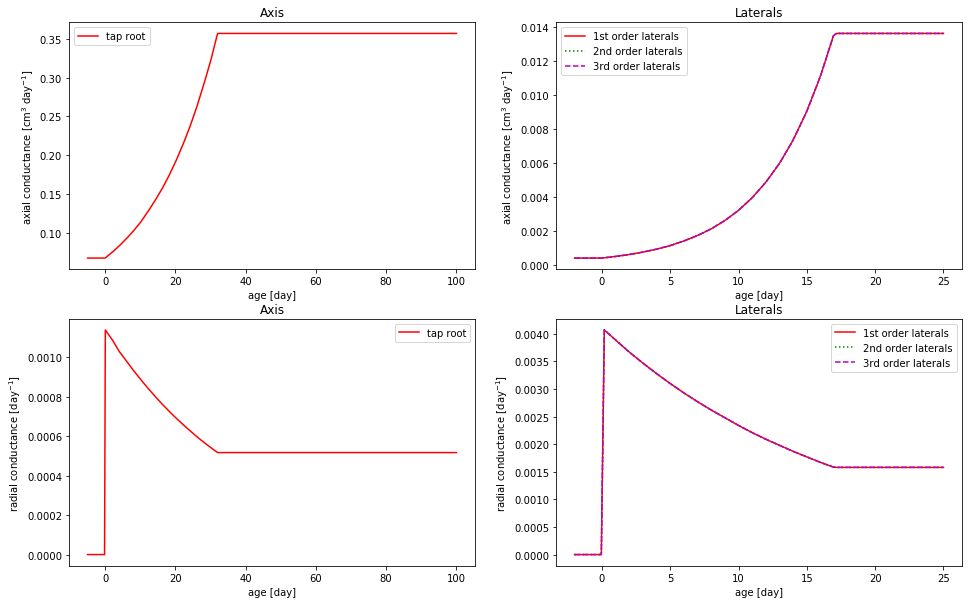

In [9]:
# tabular values for age and type depenent case [age, value] for type 0 (kr0), and type 1 (kr1)
kr_collar = np.array([[0., 0.]])
kr1 = np.array([[-1e4, 1.e-9], [0., 1.e-9], [0, 1.14e-03], [2, 1.09e-03], [4, 1.03e-03], [6, 9.83e-04], [8, 9.35e-04], [10, 8.90e-04], [12, 8.47e-04], [14, 8.06e-04], [16, 7.67e-04], [18, 7.30e-04], [20, 6.95e-04], [22, 6.62e-04], [24, 6.30e-04], [26, 5.99e-04], [28, 5.70e-04], [30, 5.43e-04], [32, 5.17e-04]])
kr2 = np.array([[-1e4, 1.e-9], [0., 1.e-9], [0, 4.11e-03], [1, 3.89e-03], [2, 3.67e-03], [3, 3.47e-03], [4, 3.28e-03], [5, 3.10e-03], [6, 2.93e-03], [7, 2.77e-03], [8, 2.62e-03], [9, 2.48e-03], [10, 2.34e-03], [11, 2.21e-03], [12, 2.09e-03], [13, 1.98e-03], [14, 1.87e-03], [15, 1.77e-03], [16, 1.67e-03], [17, 1.58e-03]])

# XylemFlux::setKrTables(values, ages) in src/XylemFlux.h
r.setKrTables([kr_collar[:, 1], kr1[:, 1], kr2[:, 1], kr2[:, 1], kr2[:, 1]], 
              [kr_collar[:, 0], kr1[:, 0], kr2[:, 0], kr2[:, 0], kr2[:, 0]])  # [cm^3/day]

kx_collar = np.array([[0., 1.]])
kx1 = np.array([[0, 6.74e-02], [2, 7.48e-02], [4, 8.30e-02], [6, 9.21e-02], [8, 1.02e-01], [10, 1.13e-01], [12, 1.26e-01], [14, 1.40e-01], [16, 1.55e-01], [18, 1.72e-01], [20, 1.91e-01], [22, 2.12e-01], [24, 2.35e-01], [26, 2.61e-01], [28, 2.90e-01], [30, 3.21e-01], [32, 3.57e-01]])
kx2 = np.array([[0, 4.07e-04], [1, 5.00e-04], [2, 6.15e-04], [3, 7.56e-04], [4, 9.30e-04], [5, 1.14e-03], [6, 1.41e-03], [7, 1.73e-03], [8, 2.12e-03], [9, 2.61e-03], [10, 3.21e-03], [11, 3.95e-03], [12, 4.86e-03], [13, 5.97e-03], [14, 7.34e-03], [15, 9.03e-03], [16, 1.11e-02], [17, 1.36e-02]])

r.setKxTables([kx_collar[:, 1], kx1[:, 1], kx2[:, 1], kx2[:, 1], kx2[:, 1]],
              [kx_collar[:, 0], kx1[:, 0], kx2[:, 0], kx2[:, 0], kx2[:, 0]])  # [1/day]

_ = r.plot_conductivities(monocot = False) # in src/python_modules/xylem_flux.py

In [10]:
""" Numerical solution """
trans = -1.2  # cm3/day
# rx = r.solve_neumann(simtime, trans, p_s, cells = False) #  simulation time, value, soil matric potentials, cells, soil_k=[]
# rx = r.solve_dirichlet(simtime, p0, 0, p_s, cells = False) # simulation time, value, (unused), soil matric potentials, cells, soil_k=[]
rx = r.solve(simtime, trans, 0, p_s, cells= False, wilting_point = -15000, soil_k = []) 
# simulation time, value, soil matric potential around root collar, soil matric potentials, wilting_point, cells, soil_k=[]
fluxes = r.segFluxes(simtime, rx, -200 * np.ones(rx.shape), False)  # cm3/day
print("Transpiration", r.collar_flux(simtime, rx, [p_s], k_soil = [], cells = False), "cm3/day")

""" Additional vtk plot """
ana = pb.SegmentAnalyser(r.rs)
ana.addData("rx", rx)
# _ = vp.plot_roots(ana, "rx", "Xylem matric potential (cm)") 
surfs = np.multiply(np.array(r.segLength()), 2*np.array(r.rs.radii)*np.pi)
fluxes = np.divide(fluxes, surfs)
ana.addData("fluxes", fluxes) 
_ = vp.plot_roots(ana, "fluxes", "Segment flux (cm/day)") 

Transpiration -1.2000000000000077 cm3/day


Next we plot the standard uptake fraction (SUF) and root sytem conductance (Krs), see also rsml_viewer.py and viewer_plots.py in /gui/viewer/.

We start with SUF

SUF total 0.0 0.10407111225059855 0.03703703703703704 1.0000000000000002


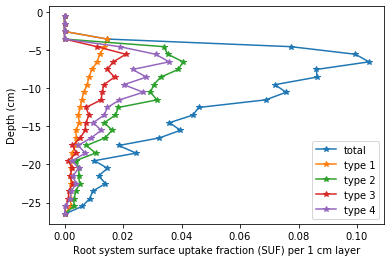

In [11]:
ana = pb.SegmentAnalyser(r.rs)
suf = r.get_suf(simtime) # in src/python_modules/xylem_flux.py, returns suf per segment
ana.addData("SUF", suf)
n = int(np.ceil(-ana.getMinBounds().z))
z_ = np.linspace(-0.5, -n + 0.5, n)
d = ana.distribution("SUF", 0., float(-n), int(n), False)  
print("SUF total", np.min(d), np.max(d), np.mean(d), np.sum(d))
plt.plot(d, z_, "-*", label = "total")

max_type = int(np.max(ana.data["subType"]))    
for i in range(1, max_type + 1):
    ana2 = pb.SegmentAnalyser(ana)  # copy
    ana2.filter("subType", i)
    d = ana2.distribution("SUF", 0., float(-n), int(n), False)
    plt.plot(d, z_, "-*", label = "type {:g}".format(i))
    
plt.ylabel("Depth (cm)")
plt.xlabel("Root system surface uptake fraction (SUF) per 1 cm layer")
plt.legend()
plt.show()

/usr/lib/python3/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


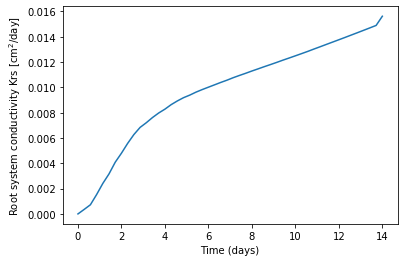

In [12]:
t_ = np.linspace(0, simtime)
krs_ = []
for t in t_:
    krs, _ = r.get_krs(t)
    krs_.append(krs)
plt.plot(t_, krs_)
plt.xlabel("Time (days)")
plt.ylabel("Root system conductivity Krs [cm$^2$/day]")
plt.show()    

## 2. Soil matric potentials per root segment

Next we couple to a soil represented by soil cells (e.g. numerical FV grid). We couple to a 1D grid using MappedSegments::setSoilGrid, see *example6a_mapping.py* for 3D using MappedSegments::setRectangularGrid (in src/MappedOrganism.cpp).

Transpiration -2.0 cm3/day
Root collar -1087.7935173766618 cm


Text(0.5, 0, 'sink [cm3/day]')

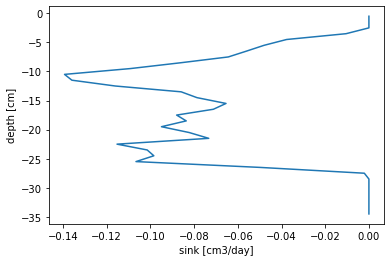

In [20]:
""" root system (as before)"""
simtime = 14  # [day] 
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
random_parameters = rs.getRootRandomParameter()
for p in random_parameters[1:]:
    p.dx = 0.25 
rs.initialize() # note that an artificial root with type =0 is added in MappedRootSystem
rs.simulate(simtime)

""" Parameters """
kz = 4.32e-2  # axial conductivity [cm^3/day]
kr = 1.728e-4  # radial conductivity [1/day]
p_top = -1000  # top soil pressure [cm]
p_bot = -100 # bot soil pressure [cm]

""" Soil cell coupling """
z_ = np.linspace(0,-35,36) # 0, -1, -2, ... -35
mids_ = 0.5*(z_[:-1] + z_[1:]) 
soil_index = lambda x,y,z : int(np.floor(-z))
rs.setSoilGrid(soil_index)

""" Linear soil index for each segment indices """
segs = rs.segments
x = np.zeros(len(segs))
for i, s in enumerate(segs):
    x[i] = rs.seg2cell[i]

""" Root problem """
r = XylemFluxPython(rs)
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial root segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Numerical solution """
p_s = np.linspace(p_top, p_bot, 35)
trans = -2  # cm3/day
rx = r.solve(simtime, trans, 0, p_s, cells= True, wilting_point = -15000, soil_k = []) 
fluxes = r.segFluxes(simtime, rx, -200 * np.ones(rx.shape), True)  # [cm3/day]
print("Transpiration", r.collar_flux(simtime, rx, p_s, k_soil = [], cells = True), "cm3/day")
print("Root collar", rx[0], "cm")

""" Additional vtk plot """
ana = pb.SegmentAnalyser(r.rs)
surfs = np.multiply(np.array(r.segLength()), 2*np.array(r.rs.radii)*np.pi)
fluxes = np.divide(fluxes, surfs)
ana.addData("fluxes", fluxes) 
ana.addData("linear_index", x) 
# _ = vp.plot_roots(ana, "fluxes", "Segment flux (cm/day)") 
_ = vp.plot_roots(ana, "linear_index", "1") 

""" Sink per soil layer """
fluxes = r.soilFluxes(simtime, rx, p_s, False, []) # approx = False, k_soil = []
# print(fluxes.keys())
# print(fluxes.values())
sink = np.zeros((35,))
for k,v in fluxes.items():
    sink[k] = v
plt.plot(sink, mids_)
plt.ylabel("depth [cm]")
plt.xlabel("sink [cm3/day]")

We can easily descrine water depletion from soil (without simulating any soil water movement )

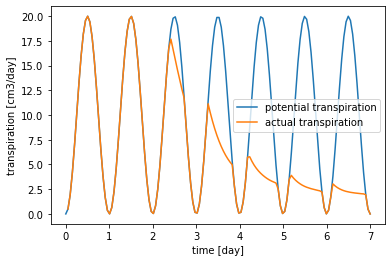

In [21]:
import van_genuchten as vg

sp = vg.Parameters([0.08, 0.43, 0.04, 1.6, 50]) # loam

def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

rs.initialize() # reset previous exmaple
initial_age = 7
rs.simulate(initial_age)

p_top = -2000  # top soil pressure [cm]
p_bot = -1000 # bot soil pressure [cm]
p_s = np.linspace(p_top, p_bot, 35)
cell_volume = 10*10*1 # [cm3]

times = np.linspace(0, 7, 140)
dt_ = np.diff(times)
t = 0 # current simulation time
t_ = [] # actual transpiration

for dt in dt_:
    
    # growth
    rs.simulate(dt)
    t += dt

    # xylem water movement
    trans = -10.*sinusoidal(t)    
    rx = r.solve(initial_age+t, trans, 0, p_s, cells= True, wilting_point = -10000, soil_k = []) 
    
    # actual tranpsiration    
    t_.append(r.collar_flux(initial_age+t, rx, p_s, k_soil = [], cells = True))
    
    # deplete soil 
    fluxes = r.soilFluxes(initial_age+t, rx, p_s, False, []) # approx = False, k_soil = []
    for k,v in fluxes.items():
        water_content = vg.water_content(p_s[k]-mids_[k],sp)
        water_content += v*dt / cell_volume 
        p_s[k] = vg.pressure_head(water_content,sp)+mids_[k]
        
plt.plot(times, 10.*sinusoidal(times), label = "potential transpiration")
plt.plot(times[1:], -np.array(t_), label = "actual transpiration")
plt.xlabel("time [day]")
plt.ylabel("transpiration [cm3/day]")
plt.legend()
plt.show()

To include water movement in soil, we need to solve the Richards equation.